<a href="https://colab.research.google.com/github/vfrantc/quaternion_neurons/blob/main/real_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install git+https://github.com/TParcollet/Quaternion-Neural-Networks.git

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 21.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TParcollet/Quaternion-Neural-Networks.git to /tmp/pip-req-build-e45cs9sg
  Running command git clone --filter=blob:none --quiet https://github.com/TParcollet/Quaternion-Neural-Networks.git /tmp/pip-req-build-e45cs9sg
  Resolved https://github.com/TParcollet/Quaternion-Neural-Networks.git to commit f8de5d5e5a3f9c694a0d62cffc64ec4ccdffd1bc
  Preparing metadata (setup.py) ... done
  Created wheel for Pytorch-QNN: filename=Pytorch_QNN-1-py3-none-any.whl size=21516 sha256=422e2f4b2975c648e6c4b03ae12e74d67c5799cfe735a9c144bba93477de66e2
  Stored in directory: /tmp/pi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# MLP iris classification

In [4]:
import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

# 3 neurons are needed to solve the problem with the real_neuron
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 3)
        self.layer2 = nn.Linear(3, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x

model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()


EPOCHS  = 250
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

print(classification_report(y_test, np.argmax(y_pred.detach(), axis=1), labels=[0, 1, 2]))

100%|██████████| 250/250 [00:00<00:00, 872.37it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.88      0.93         8
           2       0.89      1.00      0.94         8

    accuracy                           0.97        30
   macro avg       0.96      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



In [5]:
summary(model, input_size = (1, 4))

NameError: ignored

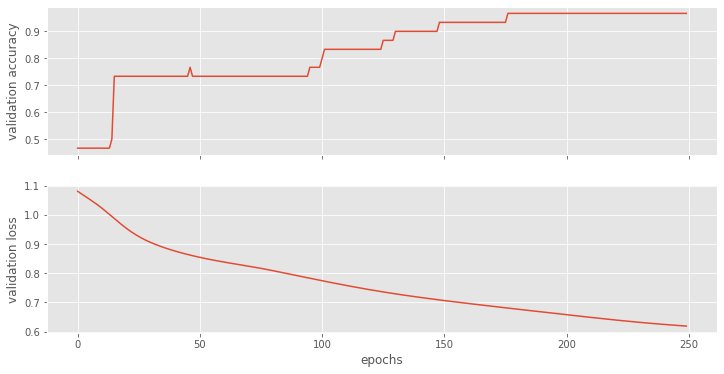

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

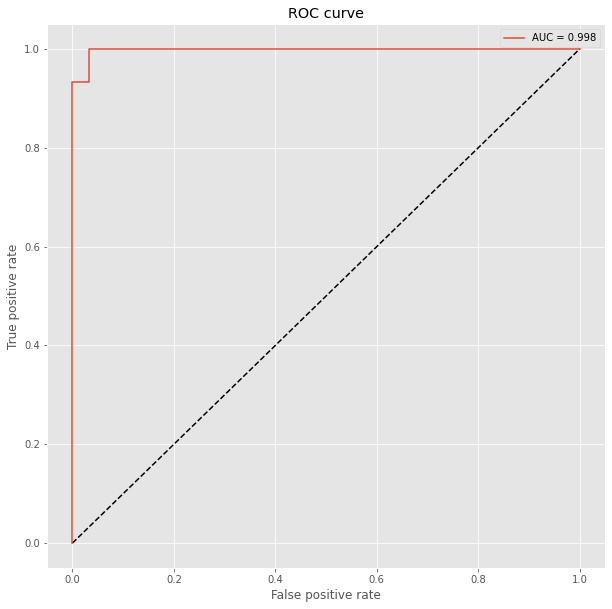

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

# Decision boundaries

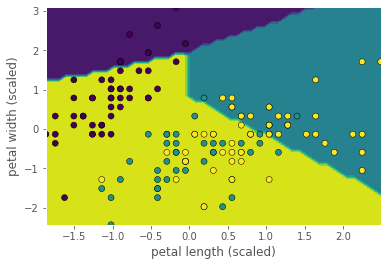

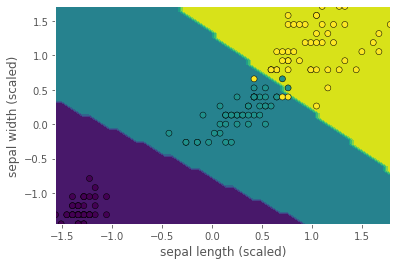

In [7]:
feature_1, feature_2, feature_3, feature_4 = np.meshgrid(
    np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max()),
    np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max()),
    np.linspace(X_scaled[:, 2].min(), X_scaled[:, 2].max()),
    np.linspace(X_scaled[:, 3].min(), X_scaled[:, 3].max())
)

grid = np.vstack([feature_1.ravel(), feature_2.ravel(), feature_3.ravel(), feature_4.ravel()]).T
grid = torch.tensor(grid, dtype=torch.float32)
prediction = model(grid).detach().numpy()
prediction = np.argmax(prediction, axis=1)

sl = 32
y_pred = np.reshape(prediction, feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_1[:, :, sl, sl], xx1=feature_2[:, :, sl, sl], response=y_pred[:, :, sl, sl])
display.plot()
display.ax_.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolor="black")
display.ax_.set_xlabel('petal length (scaled)')
display.ax_.set_ylabel('petal width (scaled)')
plt.show()

sl = 26
y_pred = np.reshape(prediction, feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_3[sl, sl, :, :], xx1=feature_4[sl, sl, :, :], response=y_pred[sl, sl, :, :])
display.plot()
display.ax_.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y, edgecolor="black")
display.ax_.set_xlabel('sepal length (scaled)')
display.ax_.set_ylabel('sepal width (scaled)')
plt.show()